# Assignment 1 - Propagation Settings

In [1]:
''' 
Copyright (c) 2010-2020, Delft University of Technology
All rigths reserved

This file is part of the Tudat. Redistribution and use in source and 
binary forms, with or without modification, are permitted exclusively
under the terms of the Modified BSD license. You should have received
a copy of the license with this file. If not, please or visit:
http://tudat.tudelft.nl/LICENSE.
'''

import numpy as np
from tudatpy import elements
from tudatpy.io import save2txt
import matplotlib
from tudatpy.kernel import constants
from tudatpy.kernel.interface import spice_interface
from tudatpy.kernel.simulation import environment_setup
from tudatpy.kernel.simulation import propagation_setup
from matplotlib import pyplot as plt

In [2]:
# student number: 1244779 --> 1244ABC
A = 3
B = 1
C = 8

simulation_start_epoch = 33.15 * constants.JULIAN_YEAR + A * 7.0 * constants.JULIAN_DAY + \
                            B * constants.JULIAN_DAY + C * constants.JULIAN_DAY / 24.0
simulation_end_epoch = simulation_start_epoch + 344.0 * constants.JULIAN_DAY / 24.0

## Create Environment and Vehicle

In [46]:
###########################################################################
# CREATE ENVIRONMENT ######################################################
###########################################################################

cases = ["1", "2", "3", "4"]

"""
unperturbed: Ganymede PM

case_i: Ganymede PM, Jupiter SH D/O 4/0

case_ii: Ganymede PM, Ganymede aerodynamic
"""

simulation_results_dict = dict()
dependent_variables_dict = dict()
for case in cases:    

# Load spice kernels.
    spice_interface.load_standard_kernels()

# Create body objects.
    if case == "1" or case == "2":
        bodies_to_create = ["Ganymede", "Jupiter"]
    if case == "3":
        bodies_to_create = ["Ganymede", "Jupiter", "Sun", "Saturn", "Europa", "Io", "Callisto"]
    if case == "4":
        bodies_to_create = ["Ganymede", "Jupiter", "Sun", "Saturn", "Europa", "Io", "Callisto"]
    
    if case == "1" or case == "3":
        global_frame_origin = "Ganymede"
    if case == "2" or case == "4":
        global_frame_origin = "Jupiter"
    
    global_frame_orientation = "ECLIPJ2000"
    body_settings = environment_setup.get_default_body_settings(
        bodies_to_create, global_frame_origin, global_frame_orientation)    

# Add Ganymede exponential atmosphere 
    density_scale_height = 40.0E3
    density_at_zero_altitude = 2.0E-9
    body_settings.get( "Ganymede" ).atmosphere_settings = environment_setup.atmosphere.exponential( 
            density_scale_height, density_at_zero_altitude)

    bodies = environment_setup.create_system_of_bodies(body_settings)

###########################################################################
# CREATE VEHICLE ##########################################################
###########################################################################

# Create vehicle object
    bodies.create_empty_body( "JUICE" )

# Set mass of vehicle
    bodies.get_body( "JUICE" ).set_constant_mass(2000.0)

# Create aerodynamic coefficients interface
    reference_area = 100.0
    drag_coefficient = 1.2
    aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
            reference_area,[drag_coefficient,0,0] )
    environment_setup.add_aerodynamic_coefficient_interface(
            bodies, "JUICE", aero_coefficient_settings );
    if case =="3" or case == "4":
        reference_area_radiation = 100.0
        radiation_pressure_coefficient = 1.2
        occulting_bodies = ["Ganymede"]
        radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
                    "Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies)
        environment_setup.add_radiation_pressure_interface(
                        bodies, "JUICE",radiation_pressure_settings )
      ###########################################################################
    # CREATE ACCELERATIONS ####################################################
    ###########################################################################

    # Define bodies that are propagated.
    bodies_to_propagate = ["JUICE"]

    # Define central bodies.
    if case == "1" or case == "3":
        central_bodies = ["Ganymede"]
    if case == "2" or case == "4":
        central_bodies = ["Jupiter"]
                    
# Define accelerations acting on vehicle.
    if case == "1":
        acceleration_settings_on_vehicle = dict(
            Ganymede = [propagation_setup.acceleration.point_mass_gravity()] 
        )
    if case == "2":
        acceleration_settings_on_vehicle = dict(
            Ganymede = [propagation_setup.acceleration.point_mass_gravity()],
        )
    if case == "3":
        acceleration_settings_on_vehicle = dict(
            Ganymede = [propagation_setup.acceleration.spherical_harmonic_gravity(2,2),
                        propagation_setup.acceleration.aerodynamic()],
            Jupiter  = [propagation_setup.acceleration.spherical_harmonic_gravity(4,0)],
            Sun      = [propagation_setup.acceleration.point_mass_gravity(),
                        propagation_setup.acceleration.cannonball_radiation_pressure()],
            Saturn   = [propagation_setup.acceleration.point_mass_gravity()],
            Europa   = [propagation_setup.acceleration.point_mass_gravity()],
            Io       = [propagation_setup.acceleration.point_mass_gravity()],
            Callisto = [propagation_setup.acceleration.point_mass_gravity()]
        )
    if case == "4":
        acceleration_settings_on_vehicle = dict(
            Ganymede = [propagation_setup.acceleration.spherical_harmonic_gravity(2,2),
                        propagation_setup.acceleration.aerodynamic()],
            Jupiter  = [propagation_setup.acceleration.spherical_harmonic_gravity(4,0)],
            Sun      = [propagation_setup.acceleration.point_mass_gravity(),
                        propagation_setup.acceleration.cannonball_radiation_pressure()],
            Saturn   = [propagation_setup.acceleration.point_mass_gravity()],
            Europa   = [propagation_setup.acceleration.point_mass_gravity()],
            Io       = [propagation_setup.acceleration.point_mass_gravity()],
            Callisto = [propagation_setup.acceleration.point_mass_gravity()]
         )

    # Create global accelerations dictionary.
    acceleration_settings = {"JUICE": acceleration_settings_on_vehicle}

    # Create acceleration models.
    acceleration_models = propagation_setup.create_acceleration_models(
            bodies, acceleration_settings, bodies_to_propagate, central_bodies)


    ###########################################################################
    # CREATE PROPAGATION SETTINGS #############################################
    ###########################################################################

    # Define initial state.
    if case == "1" or case == "3":
        system_initial_state = spice_interface.get_body_cartesian_state_at_epoch(
           target_body_name="JUICE",
           observer_body_name="Ganymede",
           reference_frame_name="ECLIPJ2000",
           aberration_corrections="NONE",
           ephemeris_time= simulation_start_epoch )
    if case == "2" or case == "4":
        system_initial_state = spice_interface.get_body_cartesian_state_at_epoch(
           target_body_name="JUICE",
           observer_body_name="Jupiter",
           reference_frame_name="ECLIPJ2000",
           aberration_corrections="NONE",
           ephemeris_time= simulation_start_epoch )

    # Save magnitude of perturbations for both cases
    dependent_variables_to_save = [propagation_setup.dependent_variable.relative_position("Ganymede","Jupiter")]
    if case == "1":
        dependent_variables_to_save = []
    if case == "2":
        dependent_variables_to_save = [propagation_setup.dependent_variable.relative_position("Ganymede","Jupiter"),
                                       propagation_setup.dependent_variable.relative_velocity("Ganymede","Jupiter")]
    if case == "3":
        dependent_variables_to_save = []
    if case == "4":
        dependent_variables_to_save = [propagation_setup.dependent_variable.relative_position("Ganymede","Jupiter"),
                                       propagation_setup.dependent_variable.relative_velocity("Ganymede","Jupiter")]
        

    # Create propagation settings.
    propagator_settings = propagation_setup.propagator.translational(
        central_bodies,
        acceleration_models,
        bodies_to_propagate,
        system_initial_state,
        simulation_end_epoch,
        output_variables = dependent_variables_to_save
    )

    # Create numerical integrator settings.
    fixed_step_size = 10.0
    integrator_settings = propagation_setup.integrator.runge_kutta_4(
        simulation_start_epoch,
        fixed_step_size
    )

    ###########################################################################
    # PROPAGATE ORBIT #########################################################
    ###########################################################################

    # Create simulation object and propagate dynamics.
    dynamics_simulator = propagation_setup.SingleArcDynamicsSimulator(
        bodies, integrator_settings, propagator_settings)
    
    simulation_results_dict[case] = dynamics_simulator.state_history
    dependent_variables_dict[case] = dynamics_simulator.dependent_variable_history

    ###########################################################################
    # PRINT FINAL PROPAGATION TIME AND STATE ##################################
    ###########################################################################

    final_time_step=list(simulation_results_dict[case].keys())[-1]
    first_time_step=list(simulation_results_dict[case].keys())[0]

    print(
        f"""
    JUICE Propagation Results of {case}.

    Final propagation time of JUICE [s]: {simulation_end_epoch}
    Final Cartesian state of JUICE is [m]: \n{
        simulation_results_dict[case][final_time_step][:]}

        """
    )

    ###########################################################################
    # SAVE RESULTS ############################################################
    ###########################################################################
    
    save2txt(solution=simulation_results_dict[case],
              filename="JUICEPropagationHistory_Q4_" + case + ".dat",
              directory="./",  # default = "./" 
              column_names=None,  # default = None 
              )
    


    JUICE Propagation Results of 1.

    Final propagation time of JUICE [s]: 1049302440.0
    Final Cartesian state of JUICE is [m]: 
[ 2.26091599e+06  6.13627192e+05 -2.10825326e+06 -1.00374153e+03
 -6.65349530e+02 -1.29055176e+03]

        

    JUICE Propagation Results of 2.

    Final propagation time of JUICE [s]: 1049302440.0
    Final Cartesian state of JUICE is [m]: 
[-9.88176243e+09  1.51614828e+10 -2.17157839e+10 -8.74971191e+03
  1.18424770e+04 -1.78384077e+04]

        

    JUICE Propagation Results of 3.

    Final propagation time of JUICE [s]: 1049302440.0
    Final Cartesian state of JUICE is [m]: 
[ 2.82965443e+06  1.31225608e+06 -4.44272785e+05 -8.71497960e+01
 -3.57498148e+02 -1.72809626e+03]

        

    JUICE Propagation Results of 4.

    Final propagation time of JUICE [s]: 1049302440.0
    Final Cartesian state of JUICE is [m]: 
[ 9.02271101e+08  5.76548061e+08  3.56367183e+07 -5.95583472e+03
  8.82618773e+03 -1.47312867e+03]

        


## Propagate Dynamics for various cases

## Pre-process Results

In [47]:
simulation_result_1 = simulation_results_dict[ '1']
simulation_result_2 = simulation_results_dict[ '2' ]
simulation_result_3 = simulation_results_dict[ '3' ]
simulation_result_4 = simulation_results_dict[ '4' ]

dependent_variables_1 = dependent_variables_dict[ '1' ]
dependent_variables_2 = dependent_variables_dict[ '2' ]
dependent_variables_3 = dependent_variables_dict[ '3' ]
dependent_variables_4 = dependent_variables_dict[ '4' ]


time = list(simulation_result_1.keys())
time_days = [ t / constants.JULIAN_DAY - simulation_start_epoch / constants.JULIAN_DAY for t in time ]

difference_in_cartesian_position_case_12 = []
difference_in_cartesian_position_case_34 = []

xgs_2 = []
xgs_4 = []

for t in time:
    r2 = np.array(simulation_result_2[t][:3])  - np.array(dependent_variables_2[t][:3])
    r4 = np.array(simulation_result_4[t][:3])  - np.array(dependent_variables_4[t][:3])
    difference_in_cartesian_position_case_12.append(np.linalg.norm(abs(np.array(simulation_result_1[t][:3]) - r2)))
    difference_in_cartesian_position_case_34.append(np.linalg.norm(abs(np.array(simulation_result_3[t][:3]) - r4)))
        


## Plot Results

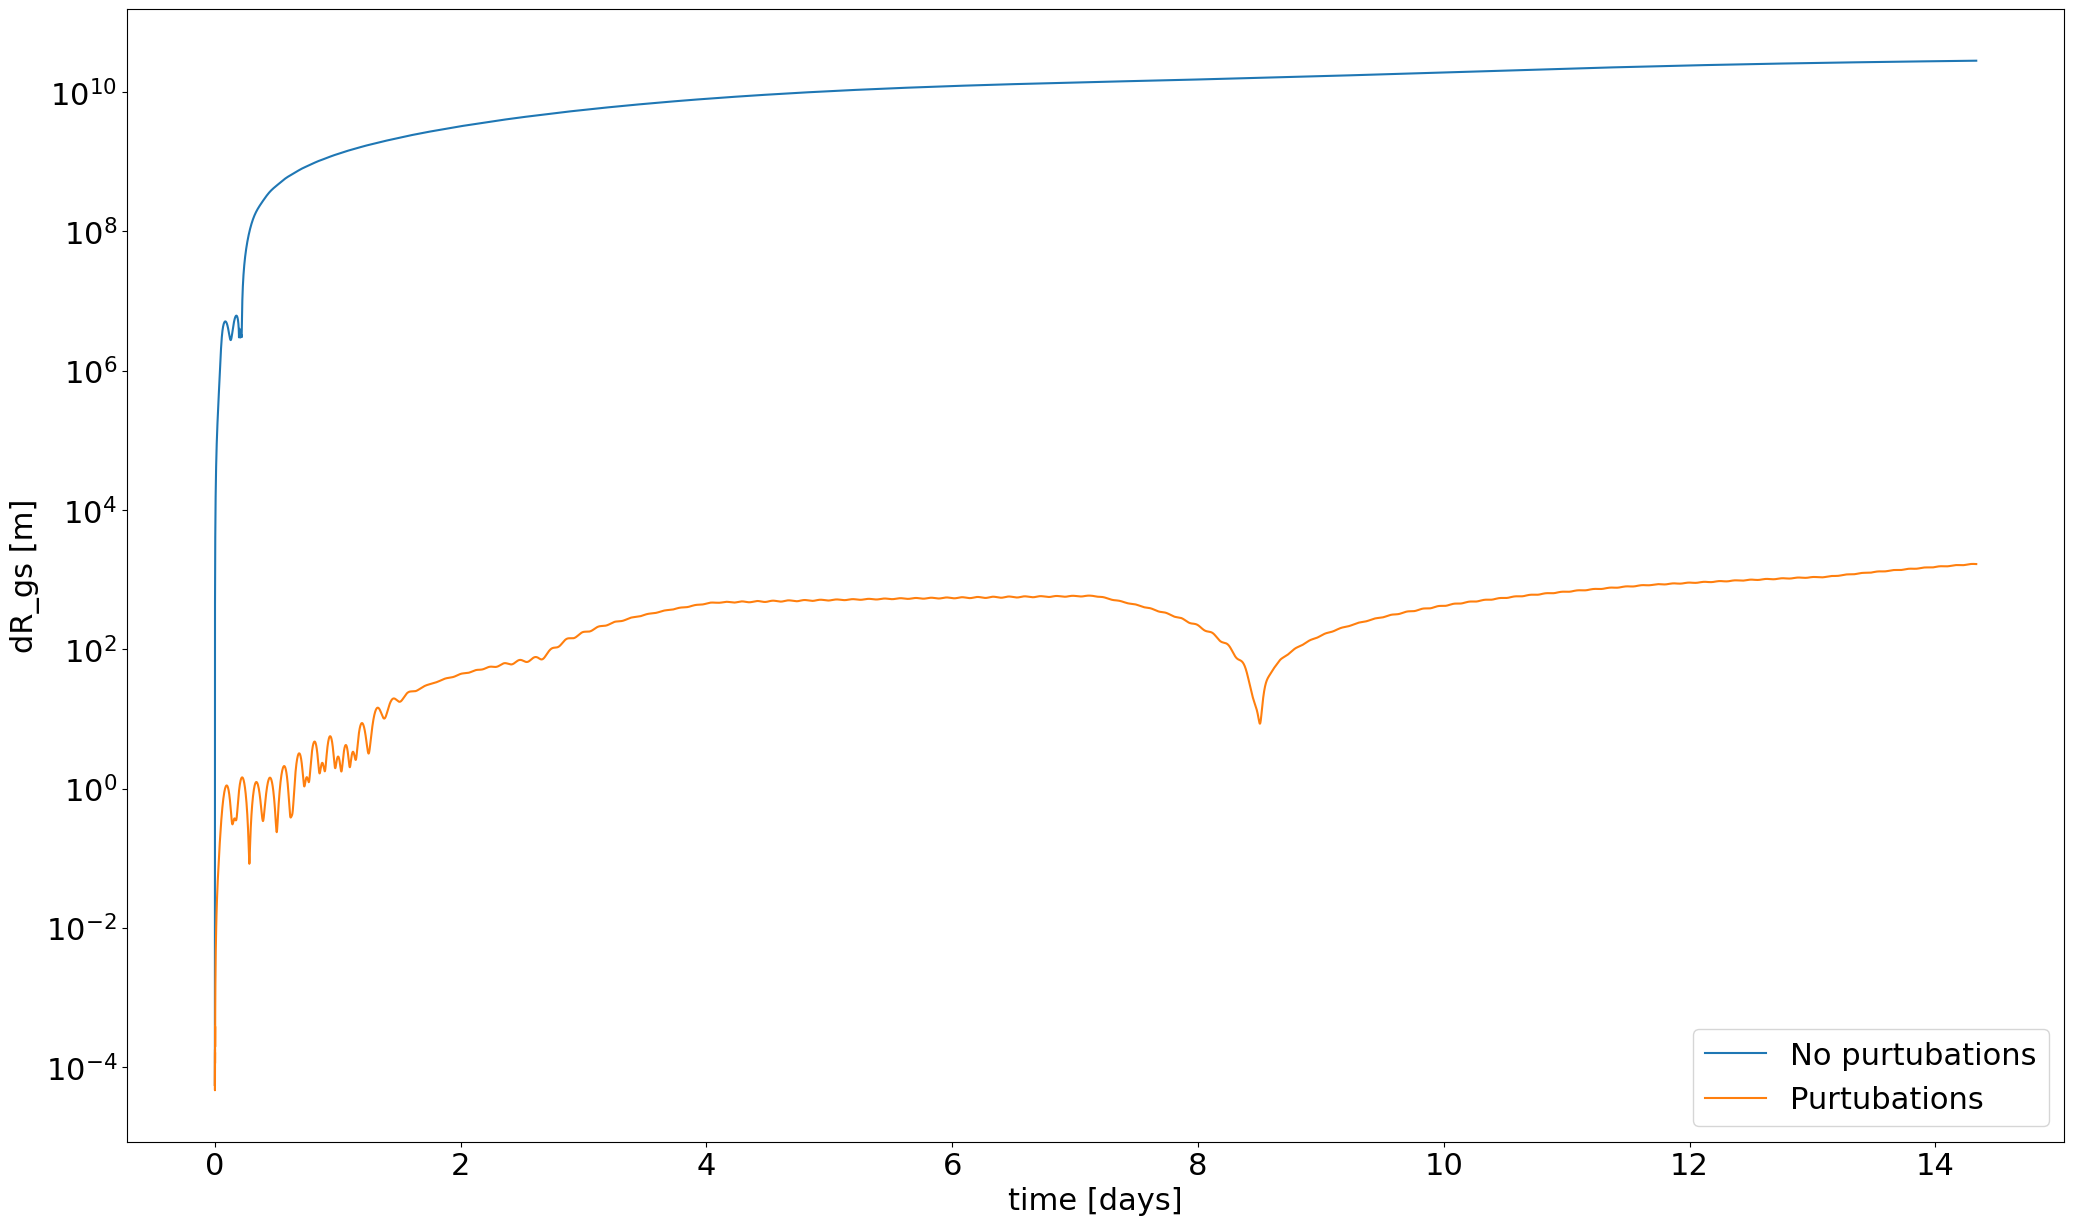

In [48]:
fig=plt.figure(figsize=(25,15), dpi= 100, facecolor='w', edgecolor='k')
matplotlib.rcParams.update({'font.size': 22})
plt.plot(time_days, difference_in_cartesian_position_case_12, label= 'No purtubations' )
plt.plot(time_days, difference_in_cartesian_position_case_34, label = 'Purtubations' )
plt.legend()
plt.yscale('log')
plt.xlabel("time [days]")
plt.ylabel("dR_gs [m]")
plt.savefig("Q5.png")

In [49]:
print(np.array(simulation_result_2[final_time_step][:])  - np.array(dependent_variables_2[final_time_step][:]))
print(np.array(simulation_result_4[final_time_step][:])  - np.array(dependent_variables_4[final_time_step][:]))

[-1.07812040e+10  1.45862467e+10 -2.17518665e+10 -2.88187161e+03
  2.65839490e+03 -1.80932431e+04]
[ 2.82956388e+06  1.31191829e+06 -4.45908249e+05 -8.79944189e+01
 -3.57894390e+02 -1.72796407e+03]
